In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import the data as a dataframe

df = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Labor')

df1 = pd.read_excel(r'CommerceLabor.xlsx', sheet_name='Department of Commerce')

In [3]:
df.head()

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
0,114016000000,DL,4.0,3.0,5.0,5.0,4.0,4.0,5.0,4,...,B,B,B,B,B,B,A,B,A,1.430425
1,137377000000,DL,2.0,2.0,5.0,4.0,4.0,2.0,5.0,2,...,B,B,B,B,A,B,B,B,A,1.712627
2,131212000000,DL,5.0,4.0,4.0,4.0,2.0,4.0,5.0,5,...,B,B,A,B,A,A,A,A,A,1.532551
3,193260000000,DL,4.0,1.0,2.0,4.0,2.0,2.0,4.0,2,...,B,B,B,A,A,A,B,A,C,2.302167
4,197278000000,DL,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3,...,B,A,B,A,A,A,A,B,C,2.918573


In [4]:
#drop the columns that aren't necessary for the project

labor_df = df[['RandomID', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q84', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'DLEAVING']].copy()


In [5]:
labor_df

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,Q52,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,B,B,B,B,B,B,A,B,A
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,2.0,B,B,B,B,A,B,B,B,A
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,B,B,A,B,A,A,A,A,A
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,1.0,B,B,B,A,A,A,B,A,C
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,5.0,B,A,B,A,A,A,A,B,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,A,B,B,A,A,A,A,B,A
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,2.0,C,B,B,A,A,A,B,B,D
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,C,B,B,A,A,A,B,B,A
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,B,B,B,A,A,A,B,B,A


In [6]:
#drop rows where the outcome variable is missing (this is what we are studying)
labor_df=labor_df.loc[labor_df['DLEAVING'].isin(['A', 'B', 'C', 'D'])]

In [7]:
labor_df

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,Q52,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,2.0,B,B,B,B,B,B,A,B,A
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,2.0,B,B,B,B,A,B,B,B,A
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,B,B,A,B,A,A,A,A,A
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,1.0,B,B,B,A,A,A,B,A,C
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,5.0,B,A,B,A,A,A,A,B,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,A,B,B,A,A,A,A,B,A
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,2.0,C,B,B,A,A,A,B,B,D
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,C,B,B,A,A,A,B,B,A
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,B,B,B,A,A,A,B,B,A


Deal With Missing Values

In [8]:
# drop rows with missing outcome data


In [9]:
#calculate percent missing for column
missing_df = pd.DataFrame(labor_df.isnull().mean()).reset_index()
missing_df.rename({'index':'variable_name',0:'percent_missing'}, axis=1, inplace=True)
missing_df

,variable_name,percent_missing
0,RandomID,0.000000
1,Q85,0.005837
2,Q86,0.010251
3,Q87,0.006264
4,Q88,0.008969
5,Q89,0.005410
6,Q2,0.013240
7,Q3,0.014237
8,Q4,0.012386
9,Q6,0.017938


In [10]:
#which rows don't have many answers? take the average of the missing data and get the proportion missing
labor_df['row_missing_percent']=labor_df.isnull().mean(axis=1)
labor_df[labor_df['row_missing_percent']!=0.0]

/var/folders/ls/s8_f754d14xcgst65tms9yz00000gn/T/ipykernel_12209/2180376194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labor_df['row_missing_percent']=labor_df.isnull().mean(axis=1)


,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
26,135718000000,4.0,4.0,4.0,4.0,5.0,3.0,3.0,4.0,3.0,...,NaN,B,B,NaN,A,NaN,NaN,B,A,0.129032
36,157819000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.258065
42,195486000000,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,2.0,...,B,B,B,B,B,B,A,B,A,0.032258
60,168710000000,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,...,NaN,B,B,B,B,C,A,A,A,0.032258
62,186250000000,3.0,4.0,4.0,4.0,4.0,4.0,3.0,NaN,NaN,...,B,B,A,B,A,C,A,B,A,0.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7524,145340000000,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,...,A,B,B,B,A,A,A,B,A,0.161290
7527,159311000000,NaN,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,...,NaN,A,B,B,B,A,B,B,C,0.064516
7528,150181000000,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,...,NaN,NaN,B,B,A,A,A,B,C,0.064516
7534,148644000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0,1.0,...,NaN,NaN,B,B,A,A,A,B,C,0.064516


<Axes: >

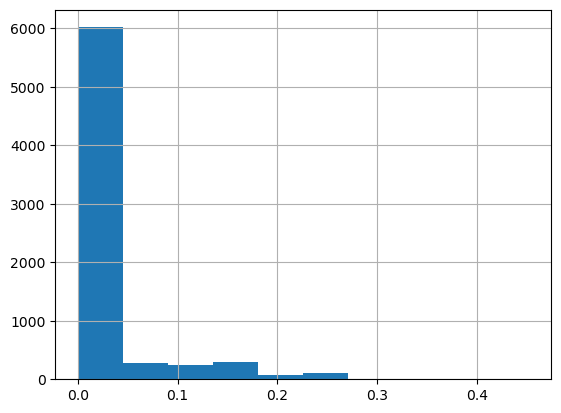

In [11]:
#plot histogram to check
labor_df['row_missing_percent'].hist()

In [12]:
# drop rows with %missing more than 50% missing data
cutpoint = .5
#drop rows w
labor_df=labor_df.loc[labor_df['row_missing_percent']<cutpoint]
labor_df

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,B,B,B,B,B,B,A,B,A,0.0
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,B,B,B,B,A,B,B,B,A,0.0
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,A,B,A,A,A,A,A,0.0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,B,B,B,A,A,A,B,A,C,0.0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,B,A,B,A,A,A,A,B,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,A,B,B,A,A,A,A,B,A,0.0
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,C,B,B,A,A,A,B,B,D,0.0
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,C,B,B,A,A,A,B,B,A,0.0
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,B,A,A,A,B,B,A,0.0


In [13]:
labor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7549
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RandomID             7024 non-null   int64  
 1   Q85                  6983 non-null   float64
 2   Q86                  6952 non-null   float64
 3   Q87                  6980 non-null   float64
 4   Q88                  6961 non-null   float64
 5   Q89                  6986 non-null   float64
 6   Q2                   6931 non-null   float64
 7   Q3                   6924 non-null   float64
 8   Q4                   6937 non-null   float64
 9   Q6                   6898 non-null   float64
 10  Q7                   6959 non-null   float64
 11  Q84                  6960 non-null   object 
 12  Q55                  7001 non-null   object 
 13  Q56                  6969 non-null   object 
 14  Q57                  6968 non-null   object 
 15  Q59                  7010 non-null   o

In [14]:
#Create an empty data frame
df_codebook = pd.DataFrame()

In [15]:
#create list of columns you want the value counts for
columns=['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52','Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89']

#loop through list and add counts to codebook
for column in columns:
    value = labor_df[column].value_counts()
    df_codebook[column] = value
    
df_codebook.head()

,Q2,Q3,Q4,Q6,Q7,Q46,Q48,Q49,Q50,Q52,Q55,Q56,Q57,Q59,Q60,Q85,Q86,Q87,Q88,Q89
4.0,2622,2849,3232,2769,3094,2339,2054,1922,1827,1741,2385,2368,3200,2150,2470,2628,3060,2407,3163,2738
5.0,2056,2476,2581,1783,3088,3281,3941,4312,3862,4112,1493,1964,1970,2664,2199,1843,2358,2015,2690,3772
3.0,1105,887,584,1131,458,709,498,414,657,721,1374,1137,904,1035,1241,1479,890,1567,803,396
2.0,721,437,348,748,176,294,258,152,300,247,781,372,427,384,501,685,400,610,158,34
1.0,427,275,192,467,143,264,210,183,304,190,747,535,380,421,499,348,244,381,147,46


<Axes: >

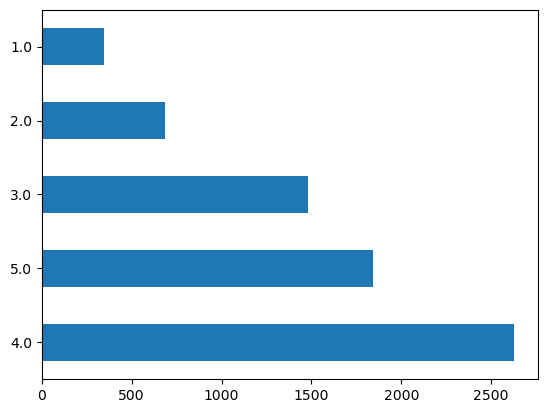

In [16]:
labor_df['Q85'].value_counts().plot(kind='barh')

In [18]:
labor_df

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,B,B,B,B,B,B,A,B,A,0.0
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,B,B,B,B,A,B,B,B,A,0.0
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,A,B,A,A,A,A,A,0.0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,B,B,B,A,A,A,B,A,C,0.0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,B,A,B,A,A,A,A,B,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,A,B,B,A,A,A,A,B,A,0.0
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,C,B,B,A,A,A,B,B,D,0.0
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,C,B,B,A,A,A,B,B,A,0.0
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,B,A,A,A,B,B,A,0.0


RECODE MISSING VALUES

In [19]:
# convert X to missing
labor_df = labor_df.replace(r'X', np.nan, regex=True)
labor_df

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,B,B,B,B,B,B,A,B,A,0.0
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,B,B,B,B,A,B,B,B,A,0.0
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,A,B,A,A,A,A,A,0.0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,B,B,B,A,A,A,B,A,C,0.0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,B,A,B,A,A,A,A,B,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,A,B,B,A,A,A,A,B,A,0.0
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,C,B,B,A,A,A,B,B,D,0.0
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,C,B,B,A,A,A,B,B,A,0.0
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,B,A,A,A,B,B,A,0.0


In [20]:
# put the columns in a list
df_columns = labor_df.columns.tolist()
df_columns

['RandomID',
 'Q85',
 'Q86',
 'Q87',
 'Q88',
 'Q89',
 'Q2',
 'Q3',
 'Q4',
 'Q6',
 'Q7',
 'Q84',
 'Q55',
 'Q56',
 'Q57',
 'Q59',
 'Q60',
 'Q46',
 'Q48',
 'Q49',
 'Q50',
 'Q52',
 'DRNO',
 'DHISP',
 'DDIS',
 'DAGEGRP',
 'DSUPER',
 'DFEDTEN',
 'DSEX',
 'DMIL',
 'DLEAVING',
 'row_missing_percent']

In [21]:
#impute with mode (doesn't mess with distribution)

for impute_column in df_columns:
    labor_df[impute_column].fillna(labor_df[impute_column].mode()[0], inplace=True)

In [22]:
#change type for numeric vars
numeric_vars = []
for num_columns in numeric_vars:
    labor_df[num_columns]=labor_df[num_columns].astype(int)

Create Dummies

In [23]:
labor_df.head()

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,row_missing_percent
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,B,B,B,B,B,B,A,B,A,0.0
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,B,B,B,B,A,B,B,B,A,0.0
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,B,B,A,B,A,A,A,A,A,0.0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,B,B,B,A,A,A,B,A,C,0.0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,B,A,B,A,A,A,A,B,C,0.0


In [24]:
#get dummies for variables in Demographic Codes (DO NOT DO THIS FOR OUTCOME & Q84)
demo_dummies = pd.get_dummies(labor_df, columns=['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL'])

demo_dummies.tail()

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B,DMIL_A,DMIL_B
7545,105014000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0,1,0,1,0,0,1,0,0,1
7546,189629000000,2.0,3.0,1.0,4.0,5.0,4.0,3.0,4.0,2.0,...,0,1,0,1,0,0,0,1,0,1
7547,125973000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1
7548,164714000000,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1
7549,177361000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0,1,0,1,0,0,0,1,0,1


In [25]:
#add dummies back into dataframe
labor_df = pd.concat([labor_df, demo_dummies], axis=1)
labor_df.head()

,RandomID,Q85,Q86,Q87,Q88,Q89,Q2,Q3,Q4,Q6,...,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B,DMIL_A,DMIL_B
0,114016000000,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,4.0,...,1,0,1,0,1,0,1,0,0,1
1,137377000000,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,2.0,...,1,1,0,0,1,0,0,1,0,1
2,131212000000,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1,1,0,1,0,0,1,0,1,0
3,193260000000,2.0,2.0,1.0,2.0,5.0,1.0,2.0,4.0,2.0,...,0,1,0,1,0,0,0,1,1,0
4,197278000000,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,...,0,1,0,1,0,0,1,0,0,1


In [19]:
#recode variable for Q84- 
#turn variable into a binary variable (do you have any unmet needs or is this org failing to meet your needs)
#Reducing
labor_df['Q84'] = np.where(labor_df['Q84'].isin(['1', '2']),1,0)

Correlation Matrix

/var/folders/ls/s8_f754d14xcgst65tms9yz00000gn/T/ipykernel_11234/2137316449.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = labor_df.corr()


<Axes: >

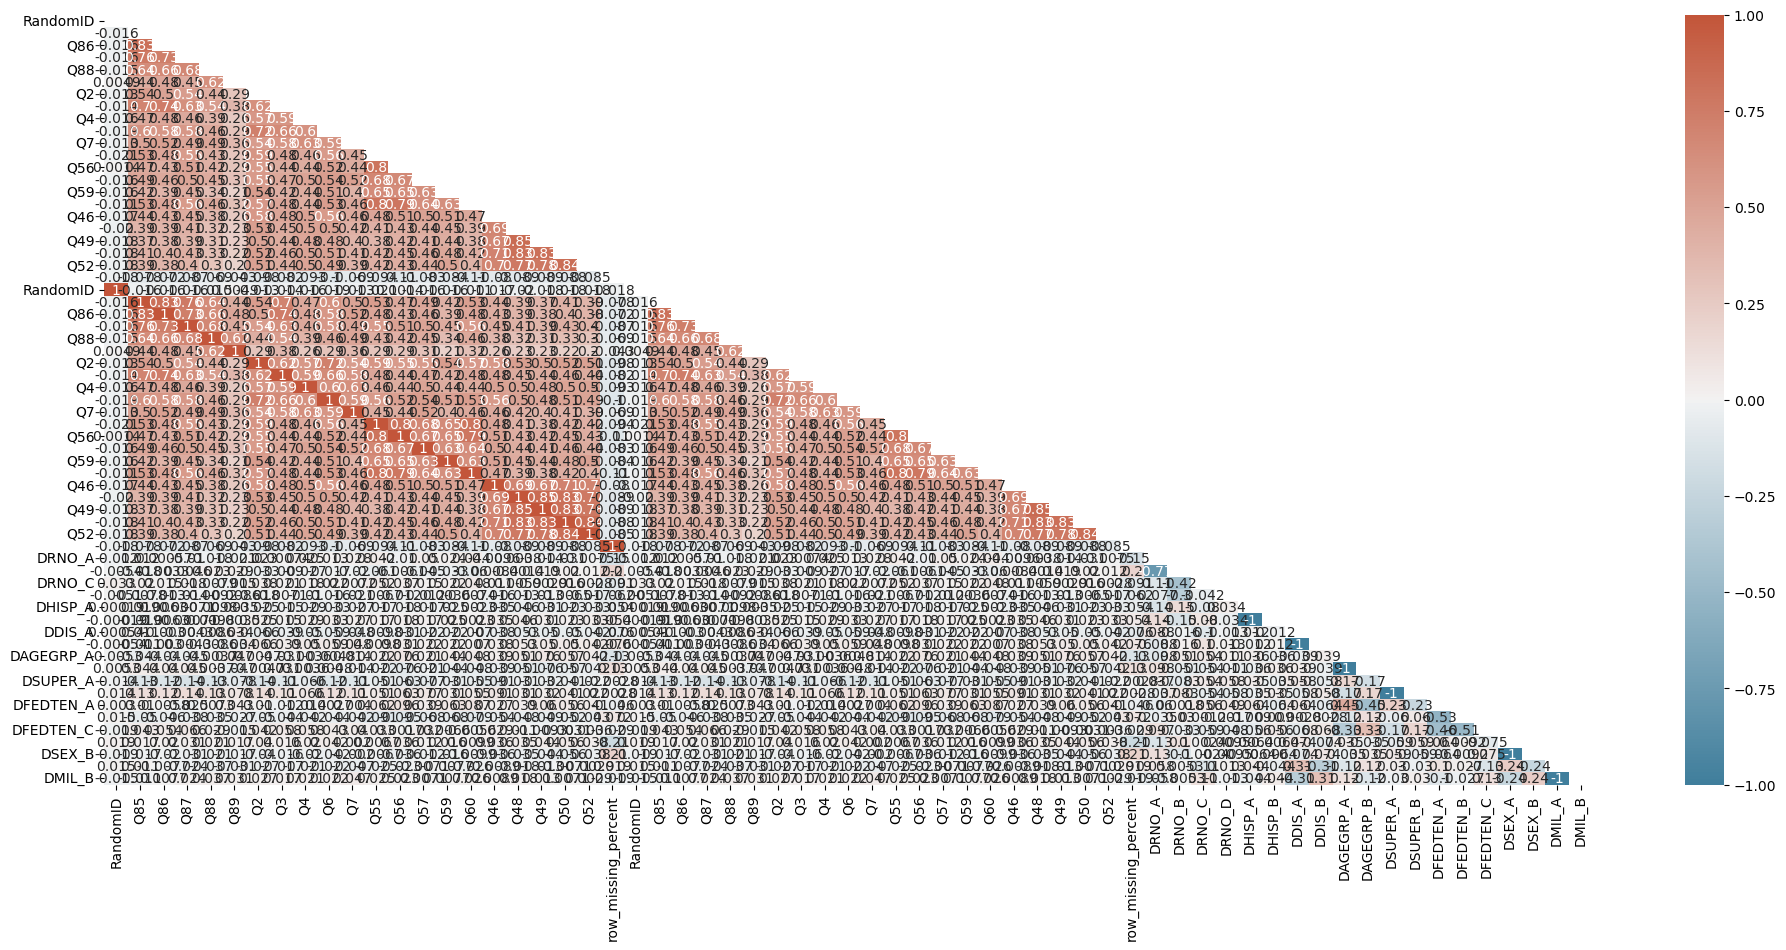

In [27]:

# Correlation between different variables
#
corr = labor_df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(24, 20))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [ ]:
corr = labor_df.corr()

In [ ]:
#if you find a dataset that is strongly correlated you can collapse into a set
#example
#test_df['new_var']=(test_df['Q55']+test_df['Q56']+test_df['Q57'])/3

Logistic Regresssion


In [ ]:
#who does this predict poorly for
#how does it predict differently for 
#different sub-populations

#identify those it identifies correctly or incorrectly to 
#check for bias

#Key course parts for executing any project: Day 1 Supervised Learning: Activities 3 & 5; Day 2 Supervised Learning Activity 5; Day 2 Unsupervised Learning Activity 4